# An Examination of Covid-19 and Vaccination in India

# Executive Summary
### Problem: 
Covid-19 is causing great harm to India
### Solution: 
analysis of Covid-19 across states can identify best/worst responding states, which can be used to improve treatment and vaccination protocols
### Key Findings:
The state in India has tremendous impact on the number of people cured of Covid-19, the number of people killed by Covid-19, and the number of adverse reactions to vaccines

# Data Source

Covid-19 in India <br>
Dataset on Novel Corona Virus Disease 2019 in India <br>
Author: Sudalairaj Kumar <br>
Data acquired from Kaggle: <br>
https://www.kaggle.com/sudalairajkumar/covid19-in-india?select=covid_19_india.csv <br>
<br>
Files acquired:
- covid_19_india.csv
- covid_vaccine_statewise.csv
- StatewiseTestingDetails.csv

# Planning <br>
### Combine covid_19_india.csv and covid_vaccine_statewise.csv into a single dataframe
### Features to be used from covid_19_india.csv:
- State
- Date
- Cured
- Deaths
<br>
### Features to be used from covid_vaccine_statewise.csv: <br>
- State
- Updated on
- Total Doses Administered
- AEFI
- Vaccine type
<br> <br>
### Overall Process
- Drop unwanted columns (or those with too many nulls)
- Clean 'State' columns in each file so that they are equivalent
- Drop 'Sno' because it can't be combined with other tables, we are going for state-wide view instead of individual patient view
- Join dataframes on 'date' and 'state' columns (after cleaning)
- Perform other data preparation
- First look at data as time-series, then as multi-factorial
<br> <br>
### Follow the standard data science pipeline:
<br>
Acquire -> Prepare -> Explore -> Model -> Delivery


# Acquire

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from scipy.stats import pearsonr, spearmanr, ttest_ind

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

# Sets precision of 2 and suppresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Seperates thousands, millions, etc with commas
pd.options.display.float_format = '{:,}'.format



In [2]:
df = pd.read_csv('covid_19_india.csv')
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [4]:
state_from_df = pd.Series(np.unique(df['State/UnionTerritory']))
state_from_df

0                  Andaman and Nicobar Islands
1                               Andhra Pradesh
2                            Arunachal Pradesh
3                                        Assam
4                                        Bihar
5                                    Bihar****
6             Cases being reassigned to states
7                                   Chandigarh
8                                 Chhattisgarh
9                       Dadra and Nagar Haveli
10    Dadra and Nagar Haveli and Daman and Diu
11                                 Daman & Diu
12                                       Delhi
13                                         Goa
14                                     Gujarat
15                                     Haryana
16                            Himachal Pradesh
17                           Himanchal Pradesh
18                           Jammu and Kashmir
19                                   Jharkhand
20                                  Karanataka
21           

In [5]:
state_from_df.shape

(46,)

In [6]:
vaccine_df = pd.read_csv('covid_vaccine_statewise.csv')
vaccine_df.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),...,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
0,16/01/2021,India,"48,276.0","3,455.0","2,957.0","48,276.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"23,757.0","24,517.0",2.0,"48,276.0"
1,17/01/2021,India,"58,604.0","8,532.0","4,954.0","58,604.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"27,348.0","31,252.0",4.0,"58,604.0"
2,18/01/2021,India,"99,449.0","13,611.0","6,583.0","99,449.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"41,361.0","58,083.0",5.0,"99,449.0"
3,19/01/2021,India,"195,525.0","17,855.0","7,951.0","195,525.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"81,901.0","113,613.0",11.0,"195,525.0"
4,20/01/2021,India,"251,280.0","25,472.0","10,504.0","251,280.0",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"98,111.0","153,145.0",24.0,"251,280.0"


In [7]:
vaccine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Updated On                           7845 non-null   object 
 1   State                                7845 non-null   object 
 2   Total Doses Administered             7621 non-null   float64
 3   Sessions                             7621 non-null   float64
 4    Sites                               7621 non-null   float64
 5   First Dose Administered              7621 non-null   float64
 6   Second Dose Administered             7621 non-null   float64
 7   Male (Doses Administered)            7461 non-null   float64
 8   Female (Doses Administered)          7461 non-null   float64
 9   Transgender (Doses Administered)     7461 non-null   float64
 10   Covaxin (Doses Administered)        7621 non-null   float64
 11  CoviShield (Doses Administered

In [8]:
state_from_vaccine = pd.Series(np.unique(vaccine_df.State))
state_from_vaccine

0                  Andaman and Nicobar Islands
1                               Andhra Pradesh
2                            Arunachal Pradesh
3                                        Assam
4                                        Bihar
5                                   Chandigarh
6                                 Chhattisgarh
7     Dadra and Nagar Haveli and Daman and Diu
8                                        Delhi
9                                          Goa
10                                     Gujarat
11                                     Haryana
12                            Himachal Pradesh
13                                       India
14                           Jammu and Kashmir
15                                   Jharkhand
16                                   Karnataka
17                                      Kerala
18                                      Ladakh
19                                 Lakshadweep
20                              Madhya Pradesh
21           

In [9]:
# The number of states between the files is different
state_from_vaccine.shape

(37,)

In [10]:
testing_df = pd.read_csv('StatewiseTestingDetails.csv')
testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,"1,403.0",1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,"2,679.0",NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,"2,848.0",NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,"3,754.0",NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,"6,677.0",NaN,33.0


In [11]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16336 entries, 0 to 16335
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          16336 non-null  object 
 1   State         16336 non-null  object 
 2   TotalSamples  16336 non-null  float64
 3   Negative      6969 non-null   object 
 4   Positive      5662 non-null   float64
dtypes: float64(2), object(3)
memory usage: 638.2+ KB


### Takeaways from Acquire: <br>
- covid_19_india.csv has no nulls, the other two files have some columns with no or few nulls and some columns with many nulls
- covid_19_india.csv has a unique serial number for each case, the other files do not
- covid_19_india.csv has state, date, cured, deaths, and confirmed cases (no nulls in these features)
- Date is date of observation, but does not say which observation; I will assume they mean the last observation
- covid_vaccine_statewise.csv has state and general vaccine info with few nulls
- Nothing like a patient_id tying covid outcome to vaccination status
- Overall covid outcome can be tied to overall vaccination status by State
- StatewiseTestingDetails.csv has many nulls in the features that would be most usefull
- Comparison of State between files will require data cleaning
- Some column names are not coding-safe

# Prepare

In [12]:
def prepare_data(df, vaccine_df):
    # Correct issues with state names
    # Asterixes were removed from names
    # Some states had several spellings, and were combined into one form
    # Some states were not state names and were changed to null
    df = df.replace('Bihar****', 'Bihar')
    df = df.replace('Cases being reassigned to states', 'Other')
    df = df.replace('Dadra and Nagar Haveli', 'Dadra and Nagar Haveli and Daman and Diu')
    df = df.replace('Daman & Diu', 'Dadra and Nagar Haveli and Daman and Diu')
    df = df.replace('Himanchal Pradesh', 'Himachal Pradesh')
    df = df.replace('Karanataka', 'Karnataka')
    df = df.replace('Madhya Pradesh***', 'Madhya Pradesh')
    df = df.replace('Maharashtra***', 'Maharashtra')
    df = df.replace('Telengana', 'Telangana')
    df = df.replace('Unassigned', 'Other')
    vaccine_df = vaccine_df.replace('India', 'Other')
    
    # Change column names for ease-of-use
    df = df.rename(columns={'Date':'date', 
                            'State/UnionTerritory':'state',
                            'Cured':'cured', 
                            'Deaths':'deaths'})
    
    vaccine_df = vaccine_df.rename(columns={'Updated On':'date', 
                                            'State':'state', 
                                            'Total Doses Administered':'total_doses', 
                                            ' Covaxin (Doses Administered)':'covaxin', 
                                            'CoviShield (Doses Administered)':'covishield', 
                                            'Sputnik V (Doses Administered)':'sputnik'}) 
    
    # Drop unwanted columns
    df = df.drop(columns=['Sno', 'Time', 'ConfirmedIndianNational', 
                          'ConfirmedForeignNational', 'Confirmed'])
    
    vaccine_df = vaccine_df.drop(columns=['18-44 Years (Doses Administered)', 
                                          '45-60 Years (Doses Administered)', 
                                          '60+ Years (Doses Administered)',
                                          '18-44 Years(Individuals Vaccinated)',
                                          '45-60 Years(Individuals Vaccinated)',
                                          '60+ Years(Individuals Vaccinated)', 
                                          'Male(Individuals Vaccinated)', 
                                          'Female(Individuals Vaccinated)', 
                                          'Transgender(Individuals Vaccinated)', 
                                          'Total Individuals Vaccinated', 
                                          'First Dose Administered', 
                                          'Second Dose Administered', 
                                          'Male (Doses Administered)', 
                                          'Female (Doses Administered)', 
                                          'Transgender (Doses Administered)', 
                                          'Sessions', 
                                          ' Sites '])

    # Drop nulls from vaccine dataframe, date and state had no nulls
    # Assume that other nulls occured because healthcare workers do not
    # always fill out a list of things that they don't give a patient.
    # Thus, the real value is probably 0
    # The other dataframe has no nulls
    vaccine_df = vaccine_df.fillna(0)
    
    # Convert 'date' to datetime type for both dataframes
    df.date = pd.to_datetime(df.date)
    vaccine_df.date = pd.to_datetime(vaccine_df.date)
    # Set date as index for both dataframes
    df = df.set_index('date').sort_index()
    vaccine_df = vaccine_df.set_index('date').sort_index()
      
    return df, vaccine_df

df, vaccine_df = prepare_data(df, vaccine_df)

In [13]:
state_from_df = pd.Series(np.unique(df['state']))
state_from_df.shape

(37,)

In [14]:
# Both dataframes have an equal number of states
state_from_vaccine = pd.Series(np.unique(vaccine_df.state))
state_from_vaccine.shape

(37,)

In [15]:
# Columns of states appear the same
states = pd.DataFrame(pd.concat([state_from_df, state_from_vaccine], axis=1))
states

,0,1
0,Andaman and Nicobar Islands,Andaman and Nicobar Islands
1,Andhra Pradesh,Andhra Pradesh
2,Arunachal Pradesh,Arunachal Pradesh
3,Assam,Assam
4,Bihar,Bihar
5,Chandigarh,Chandigarh
6,Chhattisgarh,Chhattisgarh
7,Dadra and Nagar Haveli and Daman and Diu,Dadra and Nagar Haveli and Daman and Diu
8,Delhi,Delhi
9,Goa,Goa


In [16]:
# States from both columns are equal
state_from_df == state_from_vaccine

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
dtype: bool

In [17]:
df.head()

,state,cured,deaths
date,,,
2020-01-30,Kerala,0,0
2020-01-31,Kerala,0,0
2020-02-01,Kerala,0,0
2020-02-02,Kerala,0,0
2020-02-03,Kerala,0,0


In [18]:
vaccine_df.head()

,state,total_doses,covaxin,covishield,sputnik,AEFI
date,,,,,,
2021-01-02,Jammu and Kashmir,"21,322.0",0.0,"21,322.0",0.0,0.0
2021-01-02,Haryana,"96,304.0","3,567.0","92,737.0",0.0,0.0
2021-01-02,Kerala,"173,482.0",0.0,"173,482.0",0.0,0.0
2021-01-02,Gujarat,"284,170.0","18,250.0","265,920.0",0.0,0.0
2021-01-02,Rajasthan,"313,321.0","7,775.0","305,546.0",0.0,0.0


In [19]:
df.state.value_counts()

Kerala                                      560
Telangana                                   528
Delhi                                       528
Rajasthan                                   527
Haryana                                     526
Uttar Pradesh                               526
Tamil Nadu                                  523
Ladakh                                      523
Punjab                                      521
Karnataka                                   521
Maharashtra                                 521
Jammu and Kashmir                           521
Andhra Pradesh                              518
Uttarakhand                                 515
Odisha                                      514
West Bengal                                 512
Puducherry                                  512
Chhattisgarh                                511
Chandigarh                                  511
Gujarat                                     510
Himachal Pradesh                        

In [20]:
vaccine_df.state.value_counts()

Delhi                                       213
Gujarat                                     212
Puducherry                                  212
Uttar Pradesh                               212
Tamil Nadu                                  212
Chandigarh                                  212
Tripura                                     212
Andaman and Nicobar Islands                 212
Bihar                                       212
Nagaland                                    212
Meghalaya                                   212
Himachal Pradesh                            212
Jharkhand                                   212
Telangana                                   212
Manipur                                     212
Mizoram                                     212
Rajasthan                                   212
Ladakh                                      212
Odisha                                      212
Haryana                                     212
Other                                   

In [21]:
def combine_data(df, vaccine_df):
    df['month'] = df.index.month
    vaccine_df['month'] = vaccine_df.index.month
    
    df = df.reset_index()
    vaccine_df = vaccine_df.reset_index()
    
    df = df.drop(columns='date')
    vaccine_df = vaccine_df.drop(columns='date')
    
    # The other df only goes to month 8, so we will cap this df at 8
    # The year does not change in this dataset
    vaccine_df = vaccine_df[vaccine_df.month <= 8]
    
    # Sorting by state and then merging the two dataframes side-by-side
    # Drop one state or we will have two state columns after merging
    delhi_d = df[df.state == 'Delhi']
    delhi_v = vaccine_df[vaccine_df.state == 'Delhi'].drop(columns='state')
    delhi_s = pd.merge(delhi_d, delhi_v, on='month')
    
    tamil_d = df[df.state == 'Tamil Nadu']
    tamil_v = vaccine_df[vaccine_df.state == 'Tamil Nadu'].drop(columns='state')
    tamil_s = pd.merge(tamil_d, tamil_v, on='month')
    
    madhya_d = df[df.state == 'Madhya Pradesh']
    madhya_v = vaccine_df[vaccine_df.state == 'Madhya Pradesh'].drop(columns='state')
    madhya_s = pd.merge(madhya_d, madhya_v, on='month')
    
    
    # List of dataframes to be concatenated
    frames = [delhi_s, tamil_s, madhya_s]
    
    # Concatenate the dataframes
    # Dataframes are stacked below each other, ignoring the index
    sum_df = pd.concat(frames, ignore_index=True, axis=0)
    
    # Replace state names with numbers so that they may be used for calculations
    sum_df = sum_df.replace('Delhi', 1)
    sum_df = sum_df.replace('Tamil Nadu', 2)
    sum_df = sum_df.replace('Madhya Pradesh', 3)
    
    return sum_df
       
sum_df = combine_data(df, vaccine_df)
sum_df

,state,cured,deaths,month,total_doses,covaxin,covishield,sputnik,AEFI
0,1,0,0,3,"69,462.0","4,863.0","64,599.0",0.0,0.0
1,1,0,0,3,"443,842.0","79,096.0","314,923.0",0.0,0.0
2,1,0,0,3,"1,493,167.0","373,679.0","1,119,488.0",0.0,687.0
3,1,0,0,3,"3,415,728.0","1,054,775.0","2,360,953.0",0.0,810.0
4,1,0,0,3,"5,559,386.0","1,687,996.0","3,871,390.0",0.0,947.0
...,...,...,...,...,...,...,...,...,...
28174,3,254874,3863,2,"716,682.0","119,504.0","519,921.0",0.0,0.0
28175,3,254874,3863,2,"773,228.0","120,126.0","522,745.0",0.0,0.0
28176,3,254874,3863,2,"804,378.0","120,373.0","524,343.0",0.0,0.0
28177,3,254874,3863,2,"804,378.0","120,373.0","524,343.0",0.0,0.0


In [22]:
sum_df.state.value_counts()

1    9629
2    9457
3    9093
Name: state, dtype: int64

In [23]:
sum_df.month.value_counts()

5    4836
7    4836
4    4500
6    4500
3    4134
1    2139
2    1932
8    1302
Name: month, dtype: int64

In [24]:
# 'state' has int64 type, so it can be used for calculations
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28179 entries, 0 to 28178
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        28179 non-null  int64  
 1   cured        28179 non-null  int64  
 2   deaths       28179 non-null  int64  
 3   month        28179 non-null  int64  
 4   total_doses  28179 non-null  float64
 5   covaxin      28179 non-null  float64
 6   covishield   28179 non-null  float64
 7   sputnik      28179 non-null  float64
 8   AEFI         28179 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 1.9 MB


In [25]:
sum_df.describe().T

,count,mean,std,min,25%,50%,75%,max
state,"28,179.0",1.9809787430355938,0.8148970666696392,1.0,1.0,2.0,3.0,3.0
cured,"28,179.0","557,229.4399375422","638,619.4633498784",0.0,"9,804.0","277,484.0","828,441.0","2,524,400.0"
deaths,"28,179.0","8,485.53050143724","9,264.836433269156",0.0,435.0,"4,235.0","12,425.0","34,367.0"
month,"28,179.0",4.679122750984776,1.9332004820278503,1.0,3.0,5.0,6.0,8.0
total_doses,"28,179.0","8,005,072.918875759","8,000,295.274909517",0.0,"1,294,057.0","6,094,030.0","10,381,633.0","34,901,221.0"
covaxin,"28,179.0","1,249,405.879591185","1,087,747.1728877272",0.0,"217,158.0","1,023,820.0","2,103,455.0","3,793,500.0"
covishield,"28,179.0","6,745,927.587565208","7,023,150.103453053",0.0,"1,080,010.0","4,590,051.0","8,685,808.0","31,218,147.0"
sputnik,"28,179.0","3,782.926292629263","9,184.519012811194",0.0,0.0,0.0,525.0,"44,856.0"
AEFI,"28,179.0",421.8265374924589,377.7614784751564,0.0,85.0,316.0,809.0,"1,068.0"


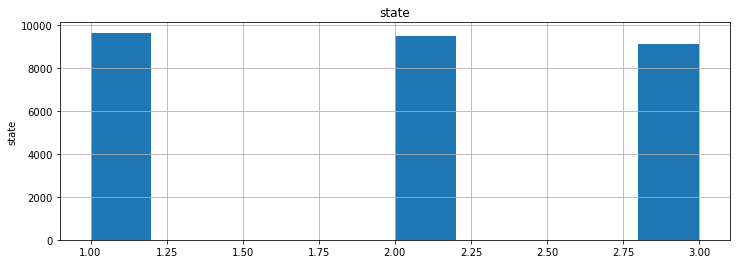

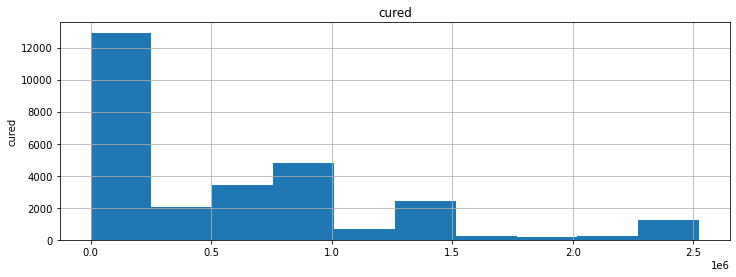

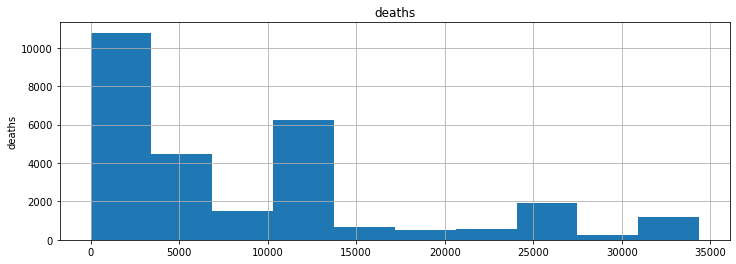

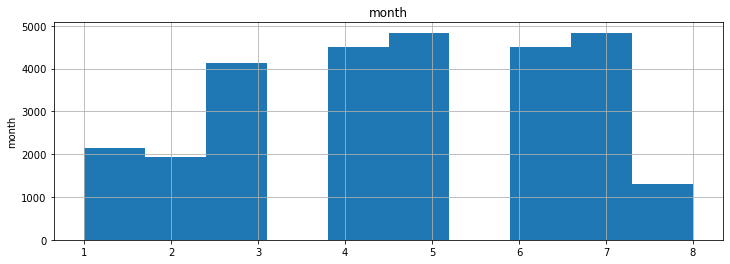

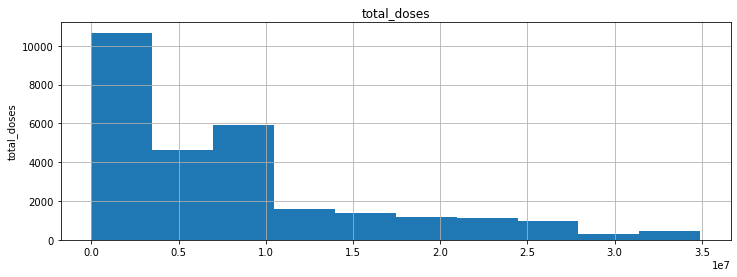

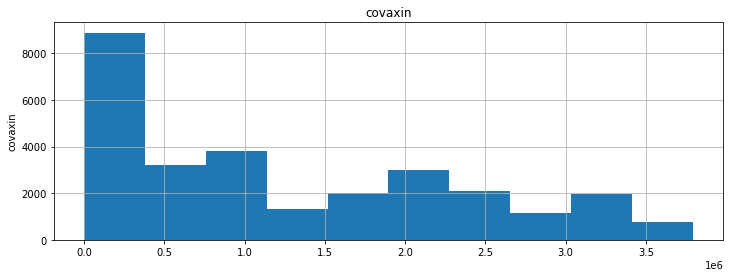

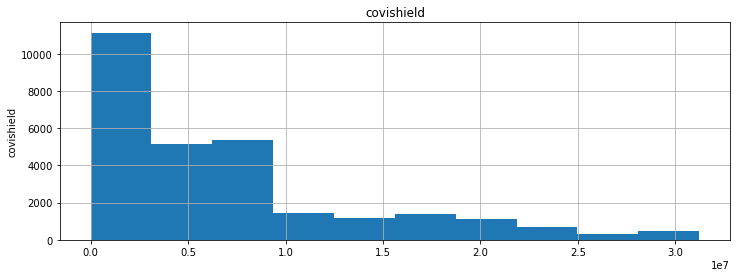

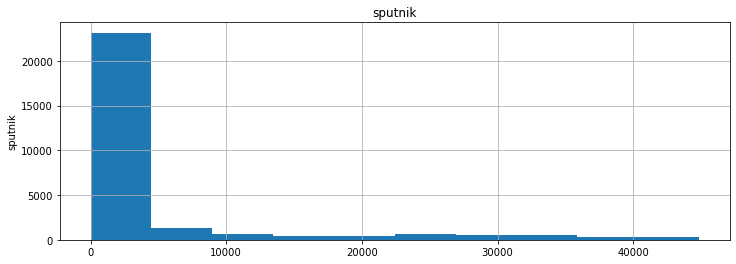

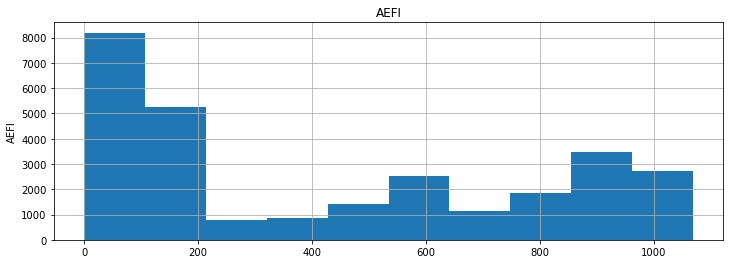

In [26]:
# Take a look at the data
for col in sum_df.columns:
    plt.figure(figsize=(12,4))
    sum_df[col].hist()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Takeaways for Prepare:
- Organized the two dataframes by month and state, and then combined the dataframes
- Huge short-lived spikes when looking at daily periods, observations may have been saved for reporting dates
- Both cured and deaths start out high and then decrease over time
- AEFI starts high, decreases largely, then slightly increases towards the end
- Vaccination in general starts high, and then decreases

# Explore

Text(0, 0.5, 'Cured')

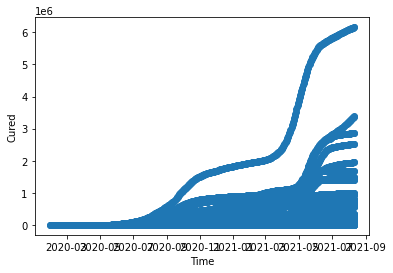

In [27]:
# Some plots have smooth curves

# This plot has multiple overlapping curves

# There are probably different groups with different survival rates

plt.scatter(df.index, df.cured)
plt.xlabel('Time')
plt.ylabel('Cured')

Text(0, 0.5, 'Total Doses Administered')

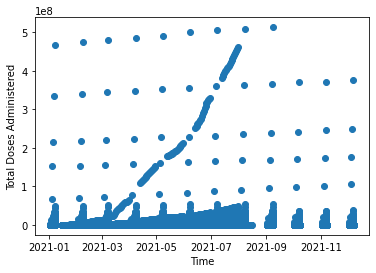

In [28]:
# Much of the vaccination data has large short-lived spikes

# This may be because clinics are holding their data until a periodic reporting date

# Different clinics may also have different procedures for reporting

# These spikes can be removed by resampling by month

plt.scatter(vaccine_df.index, vaccine_df.total_doses)
plt.xlabel('Time')
plt.ylabel('Total Doses Administered')

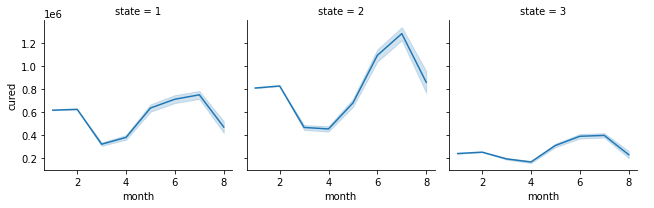

In [29]:
# Data is resampled by month and grouped by state
# This addresses issues with visualization,
# and makes data manipulation easier

grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'cured')
grid.add_legend()
plt.show()

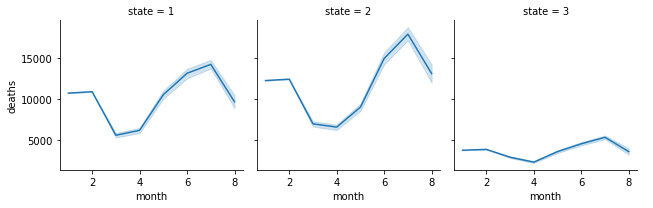

In [30]:
# The plots for cured and deaths appear almost identical

# This is because more infections means more of both cured and deaths

# Since cured/deaths are similar between states, the effictiveness
# of treating infected may also be similar between states

# The spread of infection probably differs greatly by state

# The curves for Delhi and Tamil Nadu have similar shapes
# The curve for Madhya appears suppressed
# This trend occurs for both cured and deaths
# Madhya Pradesh may have less spread of infection

grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'deaths')
grid.add_legend()
plt.show()

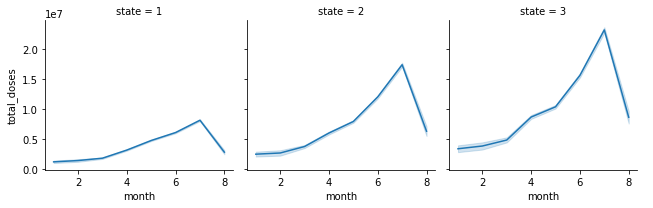

In [31]:
# Total doses administered increases to a peak, then drops sharply
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'total_doses')
grid.add_legend()
plt.show()

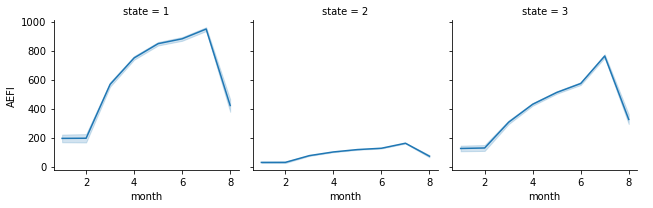

In [32]:
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'AEFI')
grid.add_legend()
plt.show()

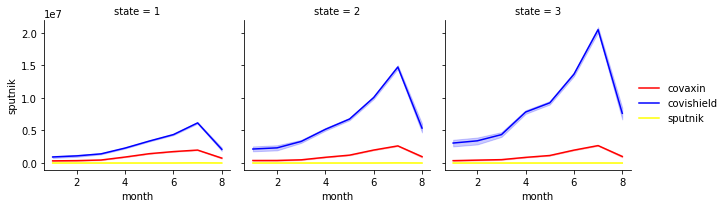

In [33]:
# In terms of doses administered:
# covishield >> covaxin > sputnik
# Vaccination increase over time and peaks at 7 months, then drops
grid = sns.FacetGrid(sum_df, col='state')
grid.map(sns.lineplot, 'month', 'covaxin', label='covaxin', color='red')
grid.map(sns.lineplot, 'month', 'covishield', label='covishield', color='blue')
grid.map(sns.lineplot, 'month', 'sputnik', label='sputnik', color='yellow')
grid.add_legend()
plt.show()

### A cycical pattern can't be seen in this time-frame
### Time-series forecasting should not be used with this dataset

In [34]:
def data_split(df):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=123, 
                                            stratify = df.month)
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=123,
                                       stratify=train_validate.month)
    return train, validate, test

# I am stratifying the split across time, because time influences most features
train, validate, test = data_split(sum_df)
train.shape, validate.shape, test.shape

((15780, 9), (6763, 9), (5636, 9))

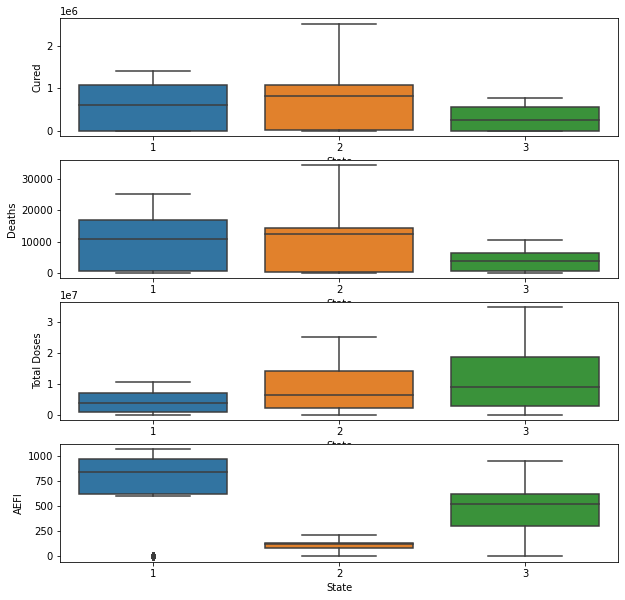

In [35]:
# Take a look at the data

# Increase the size of the figure to prevent overlapping
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1) # <- row, columns, index
sns.boxplot( x = train.state, y = train.cured)
plt.xlabel('State')
plt.ylabel('Cured')

plt.subplot(4, 1, 2)
sns.boxplot( x = train.state, y = train.deaths)
plt.xlabel('State')
plt.ylabel('Deaths')

plt.subplot(4, 1, 3)
sns.boxplot( x = train.state, y = train.total_doses)
plt.xlabel('State')
plt.ylabel('Total Doses')

plt.subplot(4, 1, 4)
sns.boxplot( x = train.state, y = train.AEFI)
plt.xlabel('State')
plt.ylabel('AEFI')

plt.show()

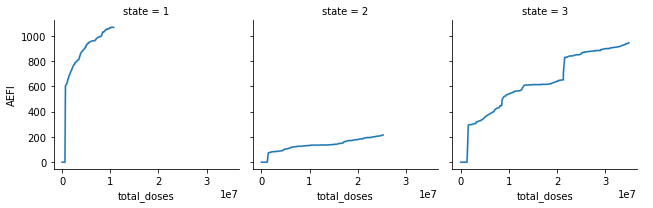

In [36]:
# Delhi is bad at infection spread and AEFI

# Tamil Nadu is bad at infection spread and good at preventing AEFI

# Madhy Pradesh is good at limiting infection spread but bad at AEFI

grid = sns.FacetGrid(train, col='state')
grid.map(sns.lineplot, 'total_doses', 'AEFI')
grid.add_legend()
plt.show()

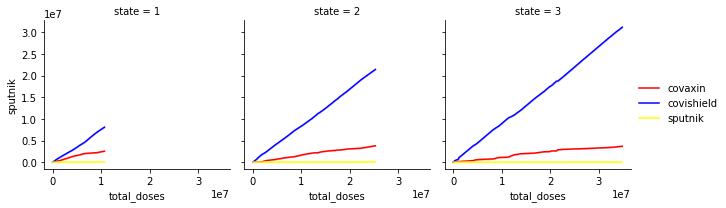

In [37]:
# In terms of doses administered:
# covishield >> covaxin > sputnik

# The ratio of vaccine types appears to be the same across states

grid = sns.FacetGrid(train, col='state')
grid.map(sns.lineplot, 'total_doses', 'covaxin', label='covaxin', color='red')
grid.map(sns.lineplot, 'total_doses', 'covishield', label='covishield', color='blue')
grid.map(sns.lineplot, 'total_doses', 'sputnik', label='sputnik', color='yellow')
grid.add_legend()
plt.show()

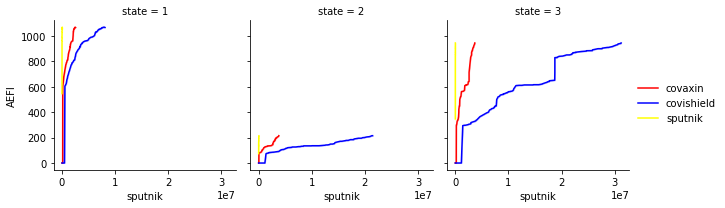

In [38]:
# The shape of the curves appears similar across states,
# the stretching of the curves is due to the different amounts of doses
# administered in different states

grid = sns.FacetGrid(train, col='state')
grid.map(sns.lineplot, 'covaxin', 'AEFI', label='covaxin', color='red')
grid.map(sns.lineplot, 'covishield', 'AEFI', label='covishield', color='blue')
grid.map(sns.lineplot, 'sputnik', 'AEFI', label='sputnik', color='yellow')
grid.add_legend()
plt.show()

In [39]:
# 'cured' has the best correlation with 'deaths'
# Surprisingly, the correlation is positive
# This may be because cured is dependent on the number of people infected
# More infections means more deaths

# 'covaxin' has the highest correlation value with AEFI, even higher than 'total_doses'

train.corr()

,state,cured,deaths,month,total_doses,covaxin,covishield,sputnik,AEFI
state,1.0,-0.17136020609193617,-0.2727995147146556,0.010723988251529329,0.36380966898920936,0.05394570345969756,0.4059684882645216,-0.18556550801301164,-0.2684079074845498
cured,-0.17136020609193617,1.0,0.9845086569512865,0.16897272238388622,0.07857073607006605,0.15806215960841172,0.06489722517908847,0.1541643591702811,-0.07126106299930106
deaths,-0.2727995147146556,0.9845086569512865,1.0,0.17017724617444277,0.030267976630224087,0.14640607993256735,0.011642704284529426,0.18898376651356405,-0.013484343100420315
month,0.010723988251529329,0.16897272238388622,0.17017724617444277,1.0,0.48653897470606333,0.5681914899953795,0.46567107481587655,0.3412770464458292,0.34115956425636856
total_doses,0.36380966898920936,0.07857073607006605,0.030267976630224087,0.48653897470606333,1.0,0.9112409619654248,0.9979309084145661,0.4486003011012625,0.35574175194961943
covaxin,0.05394570345969756,0.15806215960841172,0.14640607993256735,0.5681914899953795,0.9112409619654248,1.0,0.8829296650524578,0.5917621235676155,0.5325214559061496
covishield,0.4059684882645216,0.06489722517908847,0.011642704284529426,0.46567107481587655,0.9979309084145661,0.8829296650524578,1.0,0.418161143113761,0.3230501309892537
sputnik,-0.18556550801301164,0.1541643591702811,0.18898376651356405,0.3412770464458292,0.4486003011012625,0.5917621235676155,0.418161143113761,1.0,0.3178795203076104
AEFI,-0.2684079074845498,-0.07126106299930106,-0.013484343100420315,0.34115956425636856,0.35574175194961943,0.5325214559061496,0.3230501309892537,0.3178795203076104,1.0


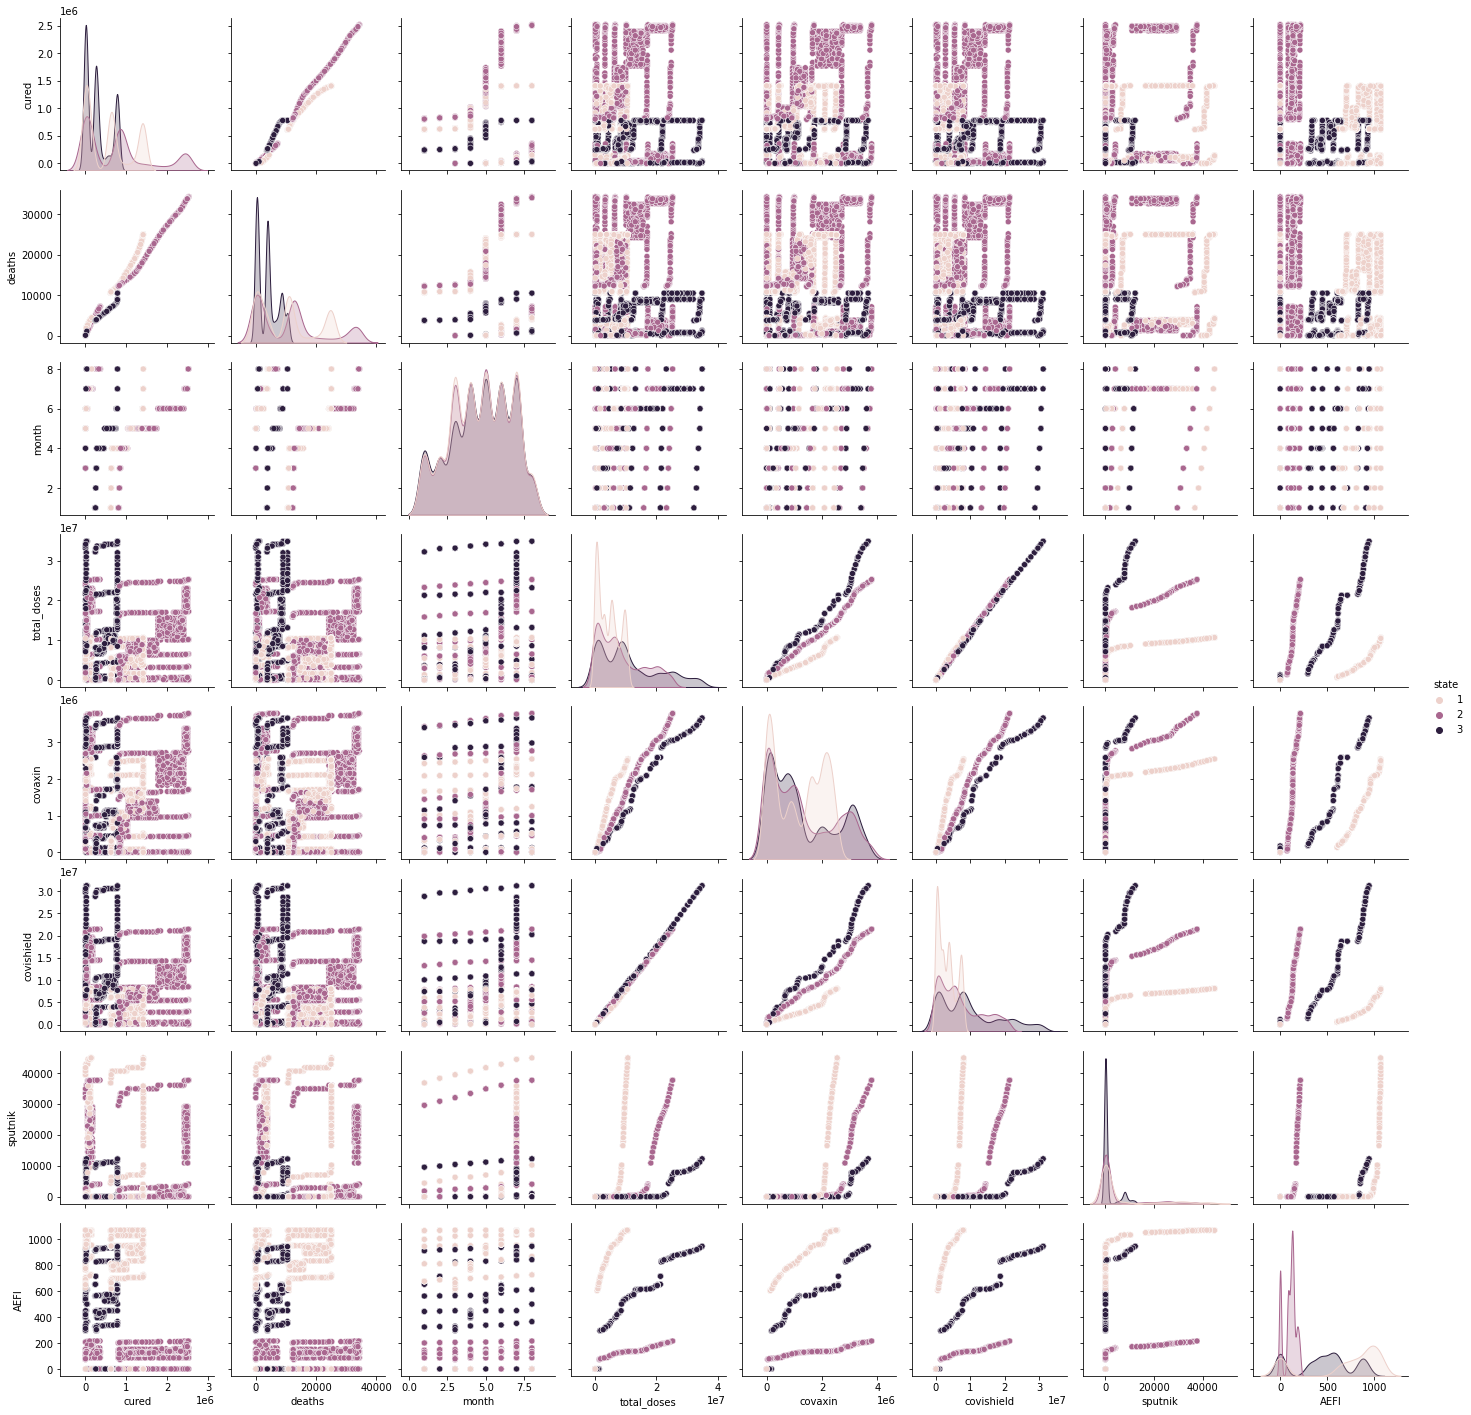

In [40]:
sns.pairplot(train, hue='state')

### Statistical Testing

H0 = state does not influence AEFI <br>
Ha = state does influence AEFI <br>
We reject H0

In [41]:
f, p = ttest_ind(train.state, train.AEFI)
f, p

(-139.78422305635988, 0.0)

H0 = state does not influence cured <br>
Ha = state does influence cured <br>
We reject H0

In [42]:
f, p = ttest_ind(train.state, train.cured)
f, p

(-110.25035150337933, 0.0)

H0 = state does not influence deaths <br>
Ha = state does influence deaths <br>
We reject H0

In [43]:
f, p = ttest_ind(train.state, train.deaths)
f, p

(-115.63613499739559, 0.0)

In addition, t-tests showed that all vaccine types influenced AEFI, but I cannot tell if this is due more to experimental design than any real effects. <br>
The proportion of the vaccine types being used was reletively constant, thus the amount of a single vaccine type being administered strongly correlates with the total amount of all vaccine types being administered. <br>
As the total amount of administered vaccines increases, one would also expect the AEFI to increase. <br>
The lack of a unique identifier connecting patient outcome and vaccination type limits what I can test statistically <br>
Therefore, I am not including the t-tests for vaccine types on AEFI.

### Takeaways from Explore
- Although data is time-series, a repeating pattern can't be found within this time-frame
- State influences cured, deaths, and AEFI
- cured strongly correlates to deaths, because more infected means both more cured and more deaths
- AEFI may be related to total_doses, this relationship differs by state
- Some daily values have limited use because of different reporting procedures for different clinics (I assume), this may be addressed by resampling by month
#### Best/Worst practices may be learned by examining differences between states

# Model

In [44]:
# I will examine the effects of 'state' on 'AEFI'
# I am choosing this target because we have little control over infection spread,
# but we have great control over circumstances leading to AEFI such as:
# brand of vaccine, age of vaccinated, health/economic status of vaccinated, etc.
# Vaccination protocols can be improved to reduce AEFI

# Dropping the target from the other features
X_train = train.drop(columns='AEFI') 
X_validate = validate.drop(columns='AEFI')
X_test = test.drop(columns='AEFI')

# Creating a set containing the target
y_train = train.AEFI
y_validate = validate.AEFI
y_test = test.AEFI

X_train.head()

,state,cured,deaths,month,total_doses,covaxin,covishield,sputnik
11978,2,866913,12789,4,"5,327,915.0","757,930.0","4,569,985.0",0.0
12283,2,902022,13071,4,"5,845,197.0","868,619.0","4,976,578.0",0.0
6203,1,58348,2742,7,"8,520,756.0","2,125,216.0","6,386,181.0","9,359.0"
19572,3,257166,3871,3,"2,970,294.0","266,221.0","2,704,073.0",0.0
24623,3,779177,8827,6,"14,443,636.0","1,970,395.0","12,473,241.0",0.0


In [45]:
y_train.head()

11978     106.0
12283     111.0
6203    1,031.0
19572     306.0
24623     611.0
Name: AEFI, dtype: float64

In [46]:
# Checking size of df's for predictors and targets
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((15780, 8), (6763, 8), (5636, 8), (15780,), (6763,), (5636,))

In [47]:
# Scale the predictive features, but not the target

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [48]:
X_train

array([[ 0.02206445,  0.48845753,  0.46792331, ..., -0.45403206,
        -0.31041619, -0.41110413],
       [ 0.02206445,  0.54378502,  0.49854447, ..., -0.35182921,
        -0.25203233, -0.41110413],
       [-1.20391116, -0.78574198, -0.62303697, ...,  0.80842877,
        -0.04962338,  0.60429879],
       ...,
       [ 1.24804007, -0.05819709, -0.26893908, ...,  0.43541685,
         0.59971739, -0.41110413],
       [ 1.24804007, -0.45799883, -0.49523163, ..., -0.93329011,
        -0.62104405, -0.41110413],
       [-1.20391116,  0.1018191 ,  0.25335801, ..., -1.15294651,
        -0.96384921, -0.41110413]])

In [49]:
# X_train and y_train were turned into np arrays, so turn them into pd dataframes

X_train = pd.DataFrame(X_train, columns = ['state', 'cured', 'deaths', 'month', 'total_doses', 'covaxin', 'covishield', 'sputnik'])
X_validate = pd.DataFrame(X_validate, columns = ['state', 'cured', 'deaths', 'month', 'total_doses', 'covaxin', 'covishield', 'sputnik'])
X_test = pd.DataFrame(X_test, columns = ['state', 'cured', 'deaths', 'month', 'total_doses', 'covaxin', 'covishield', 'sputnik'])

X_train.head()

,state,cured,deaths,month,total_doses,covaxin,covishield,sputnik
0,0.02206445345781524,0.48845752687189237,0.4679233071349787,-0.35124578320499017,-0.33558663196342153,-0.4540320610652247,-0.3104161908133456,-0.41110413424636866
1,0.02206445345781524,0.5437850152455753,0.4985444673916934,-0.35124578320499017,-0.270401022142282,-0.3518292102381091,-0.2520323325998255,-0.41110413424636866
2,-1.203911164726422,-0.7857419842753046,-0.6230369662664849,1.2005951292471082,0.06676119310479457,0.8084287715017289,-0.04962338387382047,0.60429879375599
3,1.2480400716420523,-0.4724291418850658,-0.5004437395649568,-0.8685260873556896,-0.6326836943242321,-0.9080434043545322,-0.5783478611738921,-0.41110413424636866
4,1.2480400716420523,0.3501963254718683,0.03770686409560393,0.6833148250964088,0.8131365641740197,0.6654773710201557,0.8244350676420433,-0.41110413424636866


In [50]:
# Convert y into dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

y_train.head()

,AEFI
11978,106.0
12283,111.0
6203,"1,031.0"
19572,306.0
24623,611.0


### Mean Baseline

In [51]:
# Create a mean baseline
AEFI_mean = y_train.AEFI.mean()
y_train['AEFI_pred_mean'] = AEFI_mean
y_validate['AEFI_pred_mean'] = AEFI_mean
y_test['AEFI_pred_mean'] = AEFI_mean

y_train.head()

,AEFI,AEFI_pred_mean
11978,106.0,422.55627376425855
12283,111.0,422.55627376425855
6203,"1,031.0",422.55627376425855
19572,306.0,422.55627376425855
24623,611.0,422.55627376425855


In [52]:
# RMSE of AEFI_pred_mean
rmse_train = mean_squared_error(y_train.AEFI,
                                y_train.AEFI_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.AEFI, 
                                   y_validate.AEFI_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  377.94 
Validate/Out-of-Sample:  377.86


In [53]:
# Make a table comparing metrics from the different models
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [54]:
# Create the metric_df as a blank dataframe
metric_df = pd.DataFrame()

# Make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.AEFI, y_train.AEFI_pred_mean, 'Mean Baseline', metric_df)

### Linear Regression (OLS) Model

In [55]:
# Linear regression, OLS

# Create the object
lm = LinearRegression(normalize=True)

# Fit the object
lm.fit(X_train, y_train.AEFI)

# Use the object
# Store predicted target values from linear model in new column
y_train['AEFI_pred_lm'] = lm.predict(X_train)

# Calculate RMSE for train
rmse_train = mean_squared_error(y_train.AEFI, y_train.AEFI_pred_lm) ** (1/2)

# Store predicted target values from linear model in new column
y_validate['AEFI_pred_lm'] = lm.predict(X_validate)

# Calculate RMSE for validate
rmse_validate = mean_squared_error(y_validate.AEFI, y_validate.AEFI_pred_lm) ** (1/2)

print("RMSE for LinearRegression(OLS)\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LinearRegression(OLS)
Training/In-Sample:  269.5798834268665 
Validation/Out-of-Sample:  265.86184211931794


In [56]:
# Add the linear model RMSE and R^2 values to metric_df
metric_df = metric_df.append({
    'model': 'Linear Regression (OLS)', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.AEFI, y_validate.AEFI_pred_lm)}, ignore_index=True)

### LassLars Model

In [57]:
# Create the object
lars = LassoLars(alpha=1)

# Fit the object 
# We must specify the column in y_train, 
# because we have converted it to a dataframe from a series
lars.fit(X_train, y_train.AEFI)

# Use the object
# Store predicted target values from LassoLars in new column
y_train['AEFI_pred_lars'] = lars.predict(X_train)

# Calculate RMSE for train
rmse_train = mean_squared_error(y_train.AEFI, y_train.AEFI_pred_lars) ** (1/2)

# Store predicted target values from LassoLars in new column
y_validate['AEFI_pred_lars'] = lars.predict(X_validate)

# Calculate RMSE for validate
rmse_validate = mean_squared_error(y_validate.AEFI, y_validate.AEFI_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  343.6754044719454 
Validation/Out-of-Sample:  343.2946073711664


In [58]:
# Add the LassoLars model RMSE and R^2 values to metric_df
metric_df = make_metric_df(y_validate.AEFI,
               y_validate.AEFI_pred_lars,
               'LassoLars',
               metric_df)

### Generalized Linear Model

In [59]:
# Create the object
glm = TweedieRegressor(power=1, alpha=0)


# Fit the object 
# We must specify the column in y_train, 
# becuase we  converted it to a dataframe from a series
glm.fit(X_train, y_train.AEFI)

# Use the object
# Store predicted target values from GLM in new column
y_train['AEFI_pred_glm'] = glm.predict(X_train)

# Calculate RMSE for train
rmse_train = mean_squared_error(y_train.AEFI, y_train.AEFI_pred_glm) ** (1/2)

# Store predicted target values from GLM in new column
y_validate['AEFI_pred_glm'] = glm.predict(X_validate)

# Calculate RMSE for validate
rmse_validate = mean_squared_error(y_validate.AEFI, y_validate.AEFI_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie
Training/In-Sample:  269.0438722488595 
Validation/Out-of-Sample:  264.7817598281598


In [60]:
# Add the GLM model RMSE and R^2 values to metric_df
metric_df = make_metric_df(y_validate.AEFI, 
                           y_validate.AEFI_pred_glm, 
                           'GLM', 
                           metric_df)

metric_df

,model,RMSE_validate,r^2_validate
0,Mean Baseline,377.94035857607815,0.0
1,Linear Regression (OLS),265.86184211931794,0.5049732822553358
2,LassoLars,343.2946073711664,0.17455939672670895
3,GLM,264.7817598281598,0.5090279669663336


### The Generalized Linear Model is the best performing model according to RMSE and R^2

In [61]:
# Store predicted target values from GLM in new column
y_test['AEFI_pred_glm'] = glm.predict(X_test)

# Calculate RMSE for validate
rmse_test = mean_squared_error(y_test.AEFI, y_test.AEFI_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie
Training/In-Sample:  269.0438722488595 
Validation/Out-of-Sample:  264.7817598281598


In [62]:
# Add the GLM model RMSE and R^2 values to metric_df
metric_df = make_metric_df(y_test.AEFI, 
                           y_test.AEFI_pred_glm, 
                           'GLM on Test Dataset', 
                           metric_df)

metric_df

,model,RMSE_validate,r^2_validate
0,Mean Baseline,377.94035857607815,0.0
1,Linear Regression (OLS),265.86184211931794,0.5049732822553358
2,LassoLars,343.2946073711664,0.17455939672670895
3,GLM,264.7817598281598,0.5090279669663336
4,GLM on Test Dataset,268.8953281590032,0.49169442407802544


### The Generalized Linear Model performs well on the test dataset
### This model outperforms the mean baseline and the other models

# Conclusion
The different states in India have great influence on:
- the amount of people who survived from Covid
- the amount of people who died from Covid
- the amount of adverse reactions from Covid vaccines
<br> <br>
The plots for cured mirrored the plots for deaths, implying the the number of cured and deaths recorded was mostly dependent on the spread of infection rather than treatment type <br> <br>
It could not be determined with this dataset why State had such impact on adverse reactions to vaccines. <br>
Drawing such conclusions may require a dataset with a unique identifier tying patient outcome to vaccination status <br> <br>
### This work is important because it identifies states with best/worst practices, which can be used to improve vaccine protocols

# Future Work
If I had more time, I would add other features from the dataset including: <br>
gender, age bracket, total_individuals_vaccinated / total_doses_administered <br> <br>
I would also like to find a dataset with unique identifiers tying patient outcome to vaccination information